# PUBG Dataset 

## Data Description

### winPlacePerc - Parameters
* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills   matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as * downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

## Objective.

1. To find out the most important factor that determine the final Win Place Percentage of PUBG
2. To determine an optimal machine learning model for PUBG ercentile winning placement classification
    * KNN
    * Linear Regression Model


## 0. Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=Warning)

pubg_train_origin=pd.read_csv('/Users/kris/Desktop/ProjectData/pubg-finish-placement-prediction/train.csv')

## 1.DataFrame

#### 1.1 Show the datatype of our dataset

In [2]:
print('The data types in our dataframe are:\n')
pubg_train_origin.info()

The data types in our dataframe are:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


* Categorical Data

#### 1.2 Features and Observations

* Show general information of our dataframe

In [3]:
#pd.set_option('display.max_columns', None)
#pd.set_option('max_colwidth',100)

print('There are %r obeservations and %r features in our original training data set\n\n ' % (pubg_train_origin.shape))

display(pubg_train_origin.head())

There are 4446966 obeservations and 29 features in our original training data set

 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


#### 1.3 Focus on solo match type.
* Since there are too many matchType included in our dataset(different strategy in differnt match type).
* We only focus on the matchtye that only rely on the player individual's ability -- solo.

In [4]:
pubg_train_origin['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [5]:
pubg_train=pubg_train_origin[pubg_train_origin['matchType'] == 'solo']

#### 1.4 Remove the useless feature
* We can eliminate the matchType feature as the values of all columns are solo now.
* Also, we can eliminate the DBNOs and revives feature as those features only occur in duo & squad match type.

In [6]:
pubg_train.drop(['matchType','DBNOs','revives'],axis=1,inplace=True)

In [7]:
print('There are %r obeservations and %r features in our new training data set now ' % (pubg_train.shape))

There are 181943 obeservations and 26 features in our new training data set now 


#### 1.5 Dependent Variables vs Independent Variable
* In our analysis, the dependent variable is **winPlacePerc**, all other variables are indepent variables.
* So far, the data has the following variables/features

In [8]:
variables=list(pubg_train.columns.unique())

dependent_variable=variables.pop()
independent_variables=variables

print(f'Three are {len(independent_variables)} independent variables and they are:')
print(independent_variables,sep='\n')

print('\nThe dependent variables are:')
print(dependent_variable)

Three are 25 independent variables and they are:
['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']

The dependent variables are:
winPlacePerc


#### 1.6 Check for missing data

In [9]:
if True in pubg_train.isna():
    print('Our training dataset has missing value')
else:
    print('Our training dataset does not have any missing value')

Our training dataset does not have any missing value


#### 1.7 Outliers -- Shown by Boxplot
* From the boxplot, we can see that the features about distance,longerstKill and damageDealt seem to have outliers.
* Other features seems good!

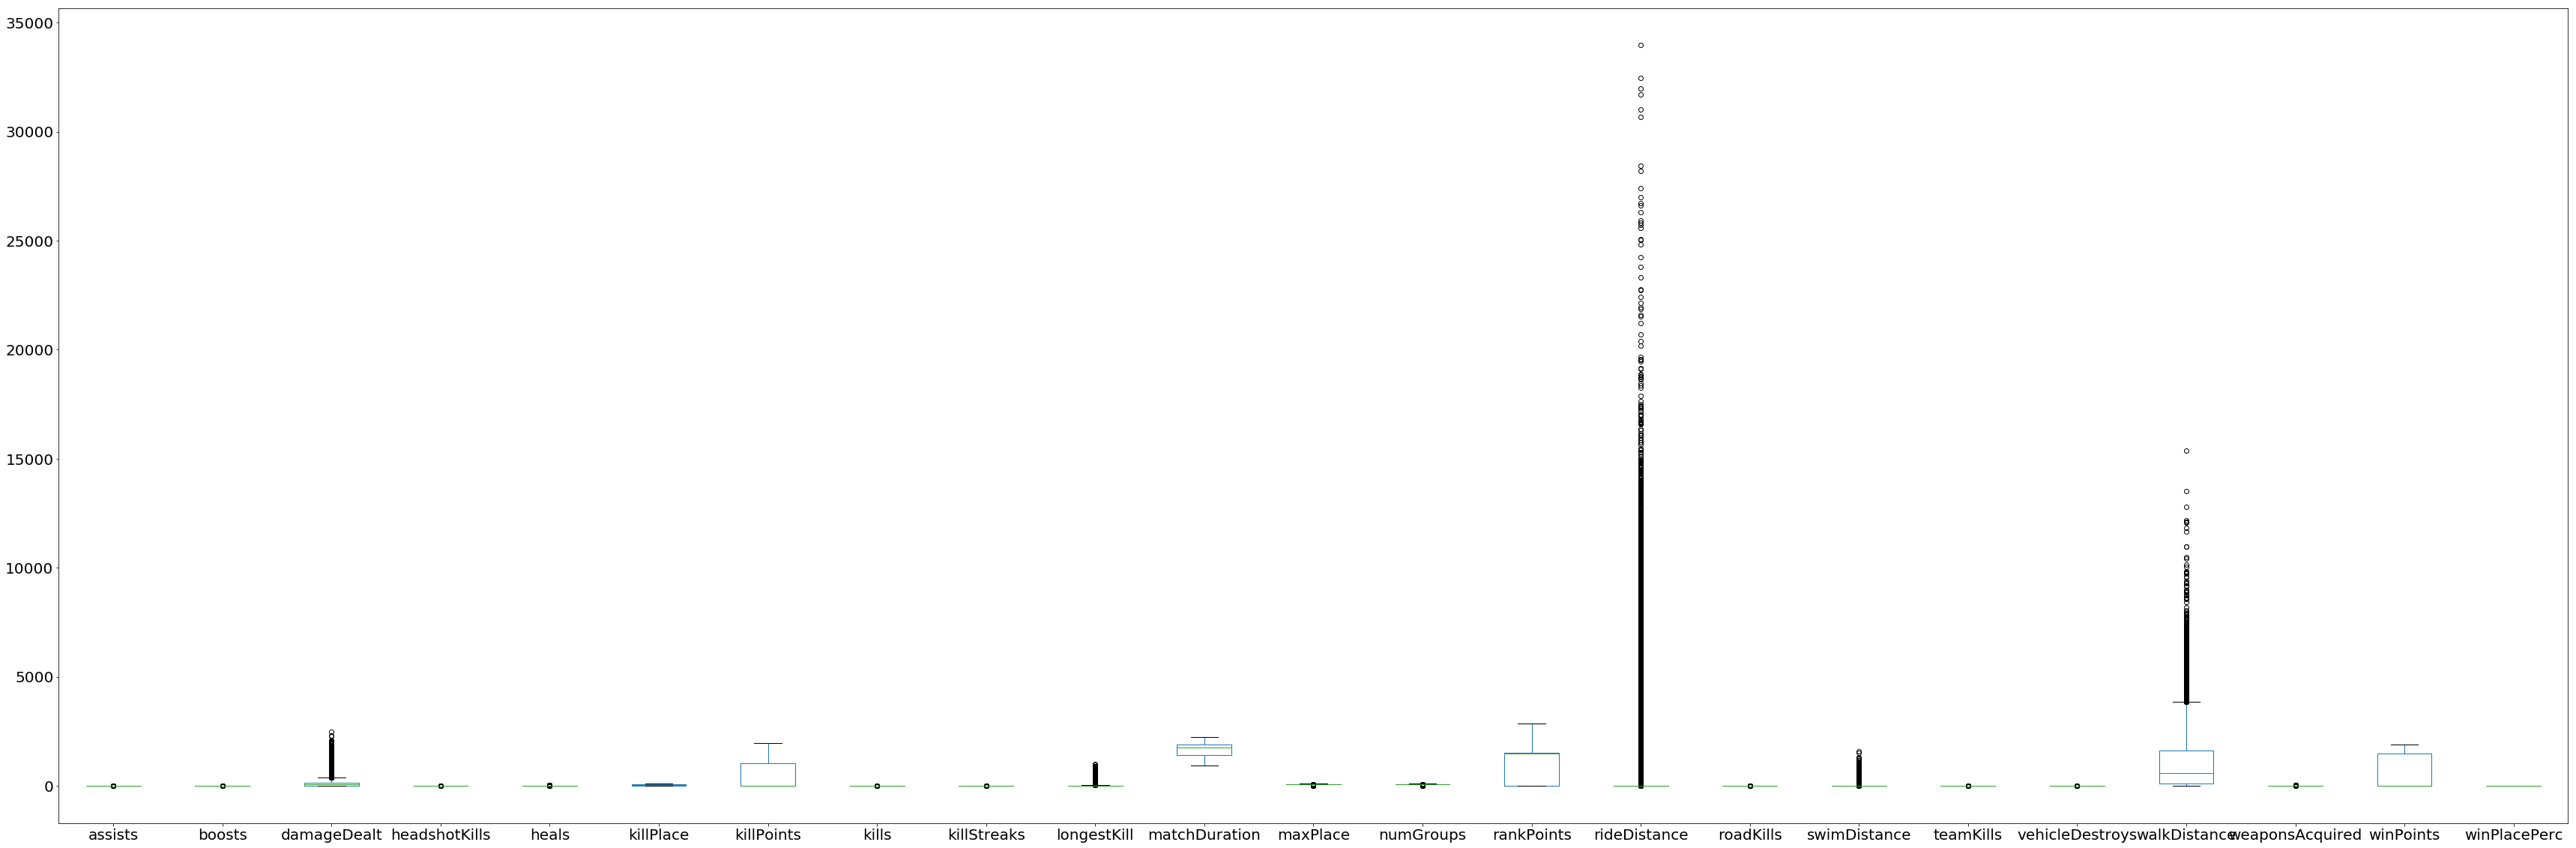

In [10]:
pubg_train.plot(kind='box',figsize=(60,20),fontsize=20.0)

#### 1.8 Outliers -- Abnormal data (Cheaters?)
* Drop the cheaters
    1. Player with more than 30 kills
    2. Player with more than 30 heals
    3. Player with weaponsAcquired more than 40

In [11]:
pubg_train.drop(pubg_train[pubg_train['kills'] > 30].index, inplace=True)

pubg_train.drop(pubg_train[pubg_train['heals'] > 30].index, inplace=True)

pubg_train.drop(pubg_train[pubg_train['weaponsAcquired'] > 40].index, inplace=True)


print('After dropping the abnormal observations, there are %r obeservations and %r features in our new training data set now ' % (pubg_train.shape))

After dropping the abnormal observations, there are 181868 obeservations and 26 features in our new training data set now 


## 2. Summary Statistics Data for each feature

In [12]:
pubg_train.describe()

,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,rankPoints,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,...,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000,181868.000000
mean,0.055617,1.064503,112.626378,0.223855,0.998356,46.177447,407.843238,0.871049,0.442964,20.700323,...,978.509496,640.044531,0.009947,5.877775,0.014967,0.007511,985.681274,3.755856,536.935629,0.473662
std,0.245156,1.823329,159.226186,0.635377,2.344673,28.005159,557.632150,1.499085,0.566249,48.369690,...,734.517488,1628.705668,0.139299,38.336898,0.121421,0.089529,1054.485643,2.541563,722.065372,0.307759
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.875000,2.000000,0.000000,0.204100
50%,0.000000,0.000000,65.770000,0.000000,0.000000,46.000000,0.000000,0.000000,0.000000,0.000000,...,1494.000000,0.000000,0.000000,0.000000,0.000000,0.000000,606.900000,3.000000,0.000000,0.468100
75%,0.000000,2.000000,159.600000,0.000000,1.000000,70.000000,1032.000000,1.000000,1.000000,15.910000,...,1510.000000,0.749775,0.000000,0.000000,0.000000,0.000000,1615.000000,5.000000,1492.000000,0.742300
max,4.000000,24.000000,2490.000000,19.000000,30.000000,100.000000,1962.000000,21.000000,18.000000,1001.000000,...,2857.000000,33970.000000,18.000000,1606.000000,1.000000,3.000000,15370.000000,35.000000,1892.000000,1.000000


* Categorical Data

In [13]:
pubg_train.describe(include=['O'])

,Id,groupId,matchId
count,181868,181868,181868
unique,181868,168507,2297
top,7dc83d07d4db75,823fb080a04aa6,1f7f0721baec0c
freq,1,21,100


## 3. Visualization 

* Since there are too many features in our dataset (26 features)
* We only choose 6 features that we think might be sinificant to explore, which are
    1. walkDistance
    2. rideDistance
    3. kills
    4. damageDealt
    5. heals
    6. weaponsAcquired

#### 3.1 WalkDistance
* The first figure shows the frequency of walkDistance
* The second fighure shows the relation between walkDistance and winPlacePerc

##### Conclusion
1. 99% of the players have a walking distance less than 4152 meters
2. Most players' walking distance are between 0 and 3000 meters.
3. The average walking distance is 985 meters
4. WalkDistance seems to have high and positive and linear relation with winPlacePerc

In [14]:
display(pubg_train['walkDistance'].quantile(0.99))
display(pubg_train['walkDistance'].describe())

4152.329999999987

count    181868.000000
mean        985.681274
std        1054.485643
min           0.000000
25%         113.875000
50%         606.900000
75%        1615.000000
max       15370.000000
Name: walkDistance, dtype: float64

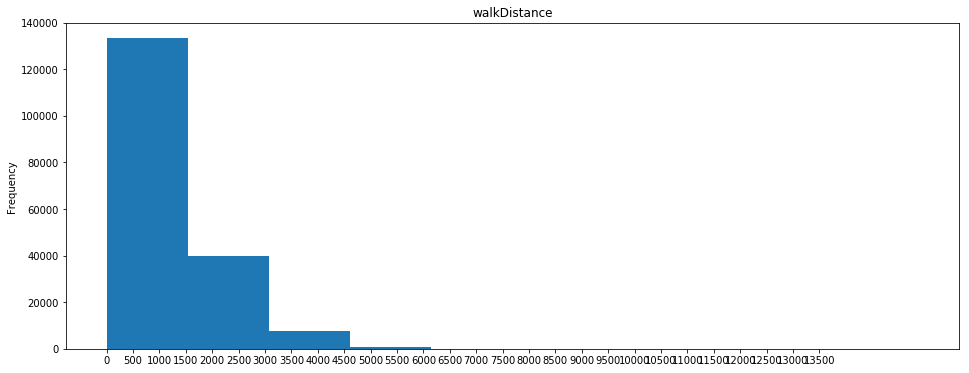

In [15]:
walkDistance_ticks=range(0,14000,500)
pubg_train['walkDistance'].plot(kind='hist',figsize=(16,6),xticks=walkDistance_ticks,title='walkDistance')

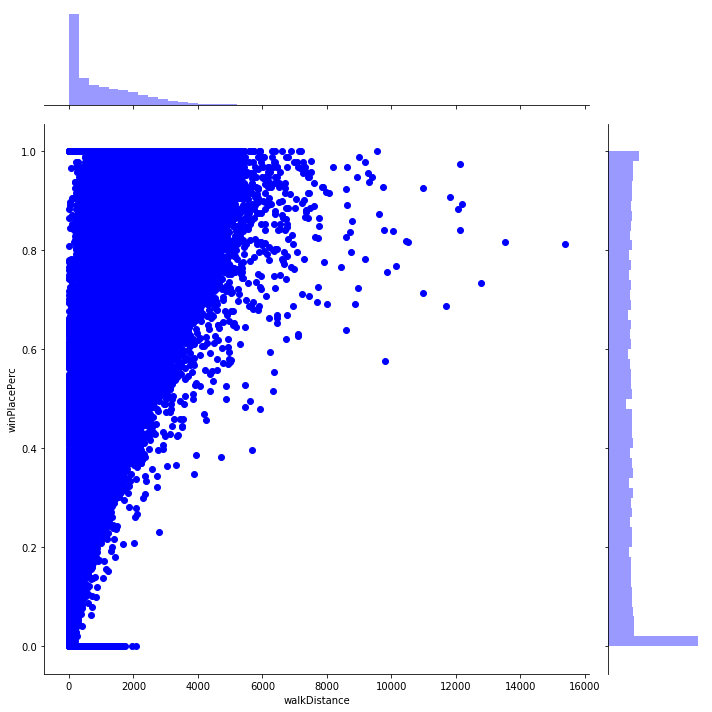

In [16]:
sns.jointplot(x="walkDistance", y="winPlacePerc", data=pubg_train, height=10, ratio=5, color="b")
plt.show()

In [1]:
a=1+2
a

3

#### 3.2 RideDistance
* The first figure shows the frequency of rideDistance
* The second fighure shows the relation between rideDistance and winPlacePerc

##### Conclusion
1. 99% of the players have a riding distance less than 7495 meters
2. Most players' riding distance are between 0 and 3000 meters.
3. The average riding distance is 640 meters
4. RideDistance seems to have relatively strong, positive and linear realtion with winPlacePerc

In [17]:
display(pubg_train['rideDistance'].quantile(0.99))
display(pubg_train['rideDistance'].describe())

7495.659999999974

count    181868.000000
mean        640.044531
std        1628.705668
min           0.000000
25%           0.000000
50%           0.000000
75%           0.749775
max       33970.000000
Name: rideDistance, dtype: float64

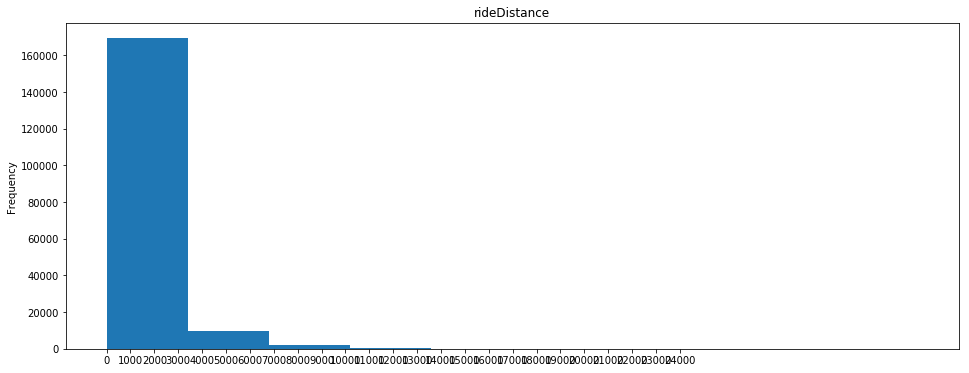

In [18]:
rideDistance_ticks=range(0,25000,1000)

pubg_train['rideDistance'].plot(kind='hist',figsize=(16,6),xticks=rideDistance_ticks,title='rideDistance')

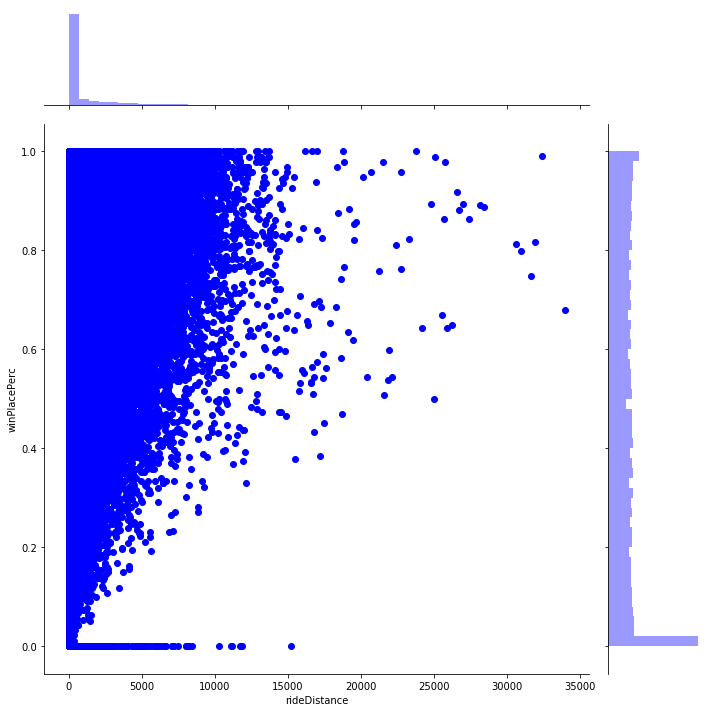

In [19]:
sns.jointplot(x="rideDistance", y="winPlacePerc", data=pubg_train, height=10, ratio=5, color="b")
plt.show()

#### 3.3 Kills
* The first figure shows the frequency of kills
* The second fighure shows the relation between kills and winPlacePerc

##### Conclusion
1. 99% of the players kill less than 8
2. Most players' kills are between 0 and 3
3. The average kill is 0.87
4. Kills seems to have weak relation with winPlacePerc

In [20]:
display(pubg_train['kills'].quantile(0.99))
display(pubg_train['kills'].describe())

7.0

count    181868.000000
mean          0.871049
std           1.499085
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          21.000000
Name: kills, dtype: float64

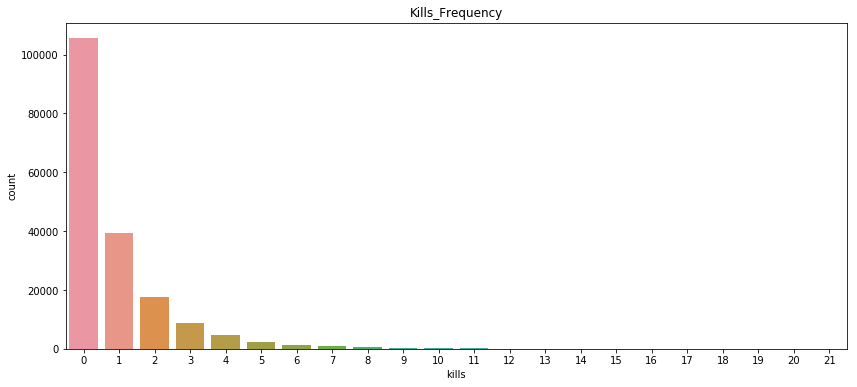

In [21]:
plt.figure(figsize=(14,6))
sns.countplot(pubg_train['kills']).set_title('Kills_Frequency')
plt.show()

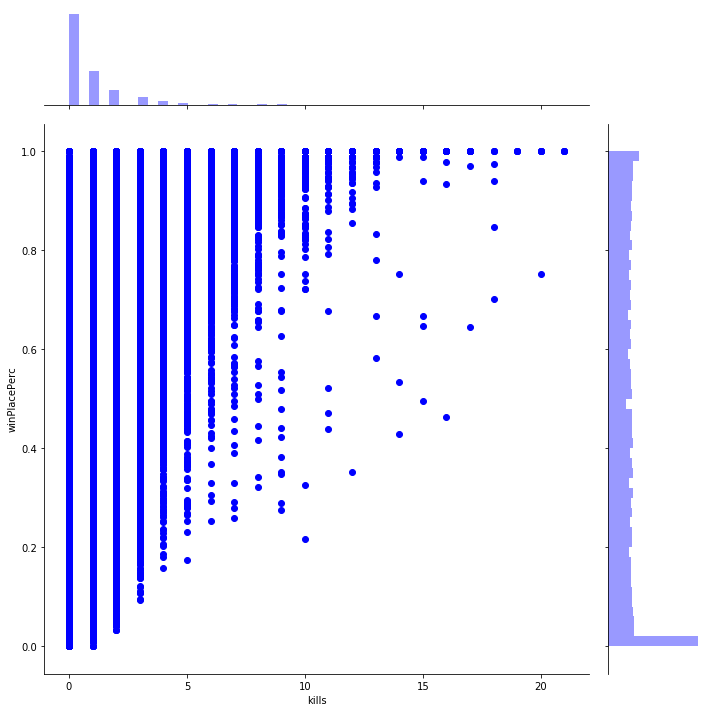

In [22]:
sns.jointplot(x="kills", y="winPlacePerc", data=pubg_train, height=10, ratio=5, color="b")
plt.show()

#### 3.4 DamageDealt
* The first figure shows the frequency of damageDealt
* The second fighure shows the relation between damageDealt and winPlacePerc

##### Conclusion
1. 99% of the players' damageDealt are less than 734
2. Most players' damageDealt are between 0 and 450
3. The average damageDealt is 112
4. DamageDealt seems to relatively strong,positive and linear realation with winPlacePerc

In [23]:
display(pubg_train['damageDealt'].quantile(0.99))
display(pubg_train['damageDealt'].describe())

734.1

count    181868.000000
mean        112.626378
std         159.226186
min           0.000000
25%           0.000000
50%          65.770000
75%         159.600000
max        2490.000000
Name: damageDealt, dtype: float64

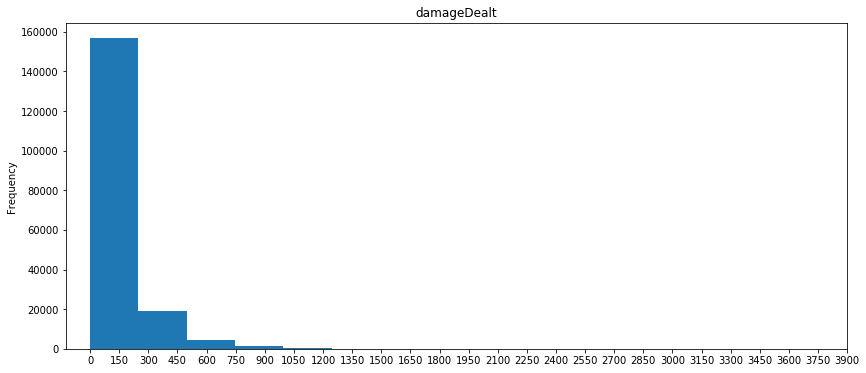

In [24]:
damageDealt_ticks=range(0,4000,150)
pubg_train['damageDealt'].plot(kind='hist',figsize=(14,6),xticks=damageDealt_ticks,title='damageDealt')

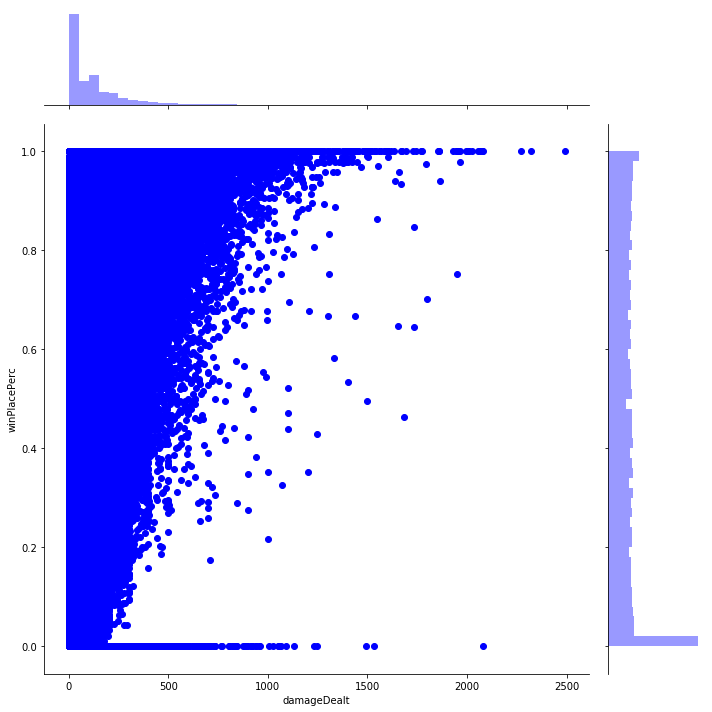

In [25]:
sns.jointplot(x="damageDealt", y="winPlacePerc", data=pubg_train, height=10, ratio=5, color="b")
plt.show()

#### 3.5 Heals
* The first figure shows the frequency of heals
* The second fighure shows the relation between heals and winPlacePerc

##### Conclusion
1. 99% of the players' heals are less than 11
2. Most players' heals are between 0 and 5
3. The average heals is 1
4. Heals seems to have weak relation with winPlacePerc

In [26]:
display(pubg_train['heals'].quantile(0.99))
display(pubg_train['heals'].describe())

11.0

count    181868.000000
mean          0.998356
std           2.344673
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          30.000000
Name: heals, dtype: float64

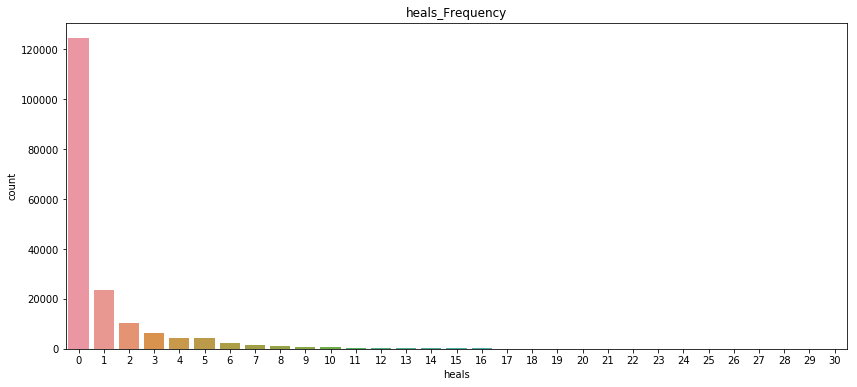

In [27]:
plt.figure(figsize=(14,6))
sns.countplot(pubg_train['heals']).set_title('heals_Frequency')
plt.show()

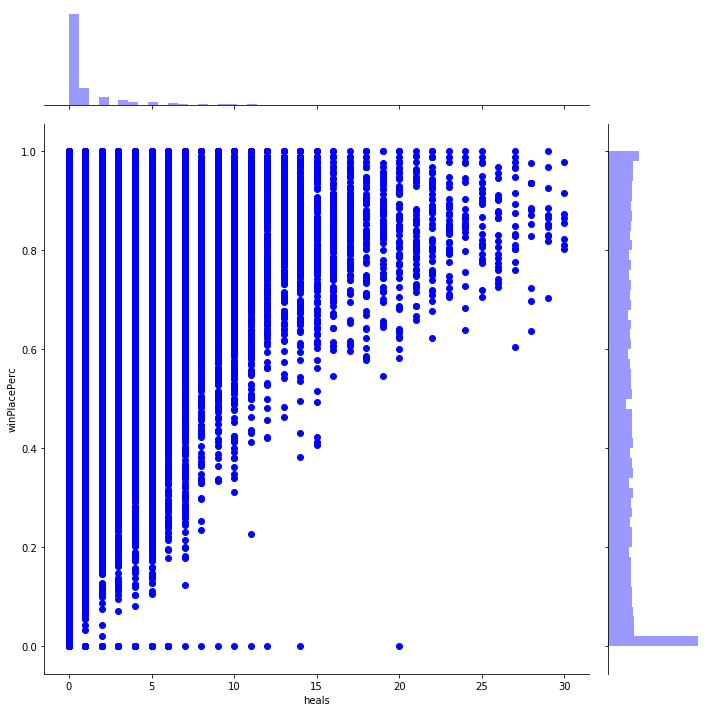

In [28]:
sns.jointplot(x="heals", y="winPlacePerc", data=pubg_train, height=10, ratio=5, color="b")
plt.show()

#### 3.6 WeaponsAcquired
* The first figure shows the frequency of weaponsAcquired
* The second fighure shows the relation between weaponsAcquired and winPlacePerc

##### Conclusion
1. 99% of the players' weaponsAcquired are less than 11
2. Most players' weaponsAcquired are between 0 and 10
3. The average weaponsAcquired is 3.7
4. weaponsAcquired seems to have a relatively weak relation with winPlacePerc

In [29]:
display(pubg_train['weaponsAcquired'].quantile(0.99))
display(pubg_train['weaponsAcquired'].describe())

11.0

count    181868.000000
mean          3.755856
std           2.541563
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          35.000000
Name: weaponsAcquired, dtype: float64

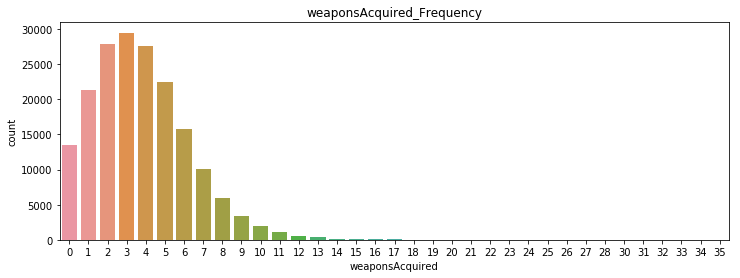

In [30]:
plt.figure(figsize=(12,4))
sns.countplot(pubg_train['weaponsAcquired']).set_title('weaponsAcquired_Frequency')
plt.show()

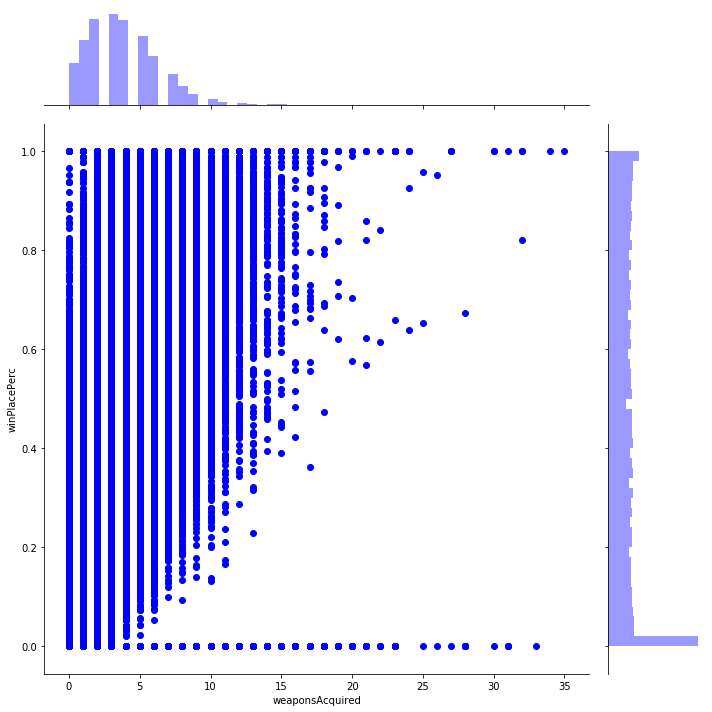

In [31]:
sns.jointplot(x="weaponsAcquired", y="winPlacePerc", data=pubg_train, height=10, ratio=5, color="b")
plt.show()

## 4. Feature Engineering
* Combine the related independent features
* Find out the independent features that have high correlation with the dependent feature -- Correlation Matrrix
* Drop the 'meaningless' features

#### 4.1 Combine highly related features
* Some of the features are highly related, we can combine them

    1. boosts_heals = boosts + heals

    2. totalDistance = walkDistance + rideDistance + swimDistance


In [32]:
pubg_train['boosts_heals'] = pubg_train['boosts'] + pubg_train['heals']

pubg_train['totalDistance'] = pubg_train['walkDistance'] + pubg_train['rideDistance']+ pubg_train['swimDistance']

* Move the dependent column to the last column
* For better observation

In [33]:
winPlacePerc_column = pubg_train.pop('winPlacePerc')

pubg_train['winPlacePerc'] = winPlacePerc_column

#### 4.2 Correlation Matrrix
* The corelation mattrix shows the relations between variables in a heatmap

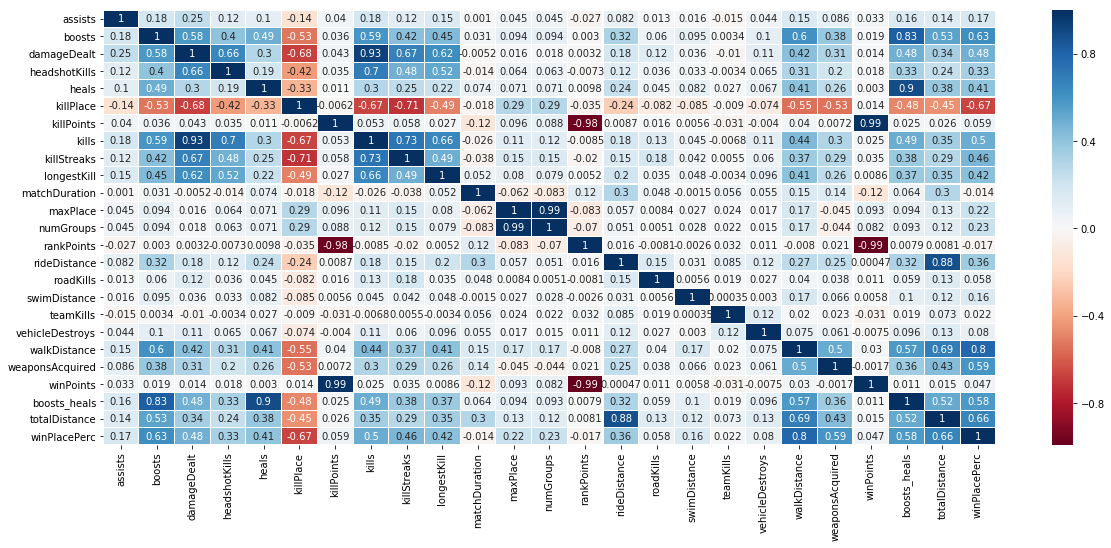

In [35]:
corr = pubg_train.corr()
plt.figure(figsize=(20,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

#### 4.3 The correlation mattrix between variables sorted by 'winPlacePerc'(dependent variable)
* The top features (8) that have high absolute correlation value with 'winPlacePerc'
* walkDistance       0.796173
* killPlace          0.672444
* totalDistance      0.660301
* boosts             0.626070
* weaponsAcquired    0.591490
* boosts_heals       0.573346
* kills              0.499903
* damageDealt        0.482135

In [36]:
pubg_train_abs=pubg_train.corr()
pubg_train_abs['winPlacePerc']= abs(pubg_train_abs['winPlacePerc'])
pubg_train_abs=pubg_train_abs.sort_values('winPlacePerc',ascending=False)
pubg_train_abs

,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,boosts_heals,totalDistance,winPlacePerc
winPlacePerc,0.169275,0.625958,0.482403,0.331437,0.405889,-0.672503,0.058719,0.500123,0.456734,0.418874,...,0.057505,0.155009,0.022098,0.079632,0.796187,0.591435,0.047279,0.579572,0.660260,1.000000
walkDistance,0.151504,0.604087,0.420384,0.305067,0.412387,-0.546206,0.039774,0.440133,0.368926,0.412203,...,0.040287,0.172928,0.019598,0.075464,1.000000,0.502222,0.030449,0.572749,0.689872,0.796187
killPlace,-0.137369,-0.526349,-0.677066,-0.423355,-0.330918,1.000000,-0.006194,-0.669993,-0.714911,-0.493826,...,-0.081836,-0.084754,-0.008996,-0.074391,-0.546206,-0.533833,0.014045,-0.480605,-0.450964,0.672503
totalDistance,0.135500,0.533845,0.339623,0.242224,0.381459,-0.450964,0.025950,0.348619,0.290425,0.352934,...,0.130797,0.124803,0.073471,0.126759,0.689872,0.433974,0.015265,0.517204,1.000000,0.660260
boosts,0.181089,1.000000,0.577026,0.401294,0.493482,-0.526349,0.036173,0.594739,0.419293,0.447301,...,0.059974,0.095356,0.003388,0.103438,0.604087,0.378282,0.018940,0.825297,0.533845,0.625958
weaponsAcquired,0.085755,0.378282,0.312749,0.198274,0.255694,-0.533833,0.007159,0.300430,0.288442,0.257738,...,0.037812,0.066356,0.023387,0.061004,0.502222,1.000000,-0.001728,0.357007,0.433974,0.591435
boosts_heals,0.158070,0.825297,0.484172,0.326758,0.898420,-0.480605,0.025182,0.494868,0.376711,0.371391,...,0.059366,0.101444,0.019185,0.095767,0.572749,0.357007,0.011494,1.000000,0.517204,0.579572
kills,0.176911,0.594739,0.930364,0.698101,0.299703,-0.669993,0.052606,1.000000,0.730142,0.657518,...,0.131163,0.045083,-0.006767,0.106649,0.440133,0.300430,0.025273,0.494868,0.348619,0.500123
damageDealt,0.247327,0.577026,1.000000,0.655719,0.297003,-0.677066,0.043205,0.930364,0.673735,0.623339,...,0.121144,0.036174,-0.010215,0.109770,0.420384,0.312749,0.014450,0.484172,0.339623,0.482403
killStreaks,0.120191,0.419293,0.673735,0.482438,0.254153,-0.714911,0.057780,0.730142,1.000000,0.487760,...,0.181012,0.041618,0.005538,0.059753,0.368926,0.288442,0.034954,0.376711,0.290425,0.456734


In [37]:
display(pubg_train_abs.shape)
print('The top 8 features that have high correlation to the dependent variable\n')
pubg_train_abs.iloc[1:9,24]

(25, 25)

The top 8 features that have high correlation to the dependent variable



walkDistance       0.796187
killPlace          0.672503
totalDistance      0.660260
boosts             0.625958
weaponsAcquired    0.591435
boosts_heals       0.579572
kills              0.500123
damageDealt        0.482403
Name: winPlacePerc, dtype: float64

In [38]:
print('The features that have low correlation to the dependent variable\n')
pubg_train_abs.iloc[9:,24]

The features that have low correlation to the dependent variable



killStreaks        0.456734
longestKill        0.418874
heals              0.405889
rideDistance       0.359765
headshotKills      0.331437
numGroups          0.226883
maxPlace           0.223839
assists            0.169275
swimDistance       0.155009
vehicleDestroys    0.079632
killPoints         0.058719
roadKills          0.057505
winPoints          0.047279
teamKills          0.022098
rankPoints         0.016992
matchDuration      0.013789
Name: winPlacePerc, dtype: float64

#### 4.4 Drop the 'relatively meaningless' features

In [39]:
print('Before dropping, we have %r observations and %r features ' % (pubg_train.shape))

Before dropping, we have 181868 observations and 28 features 


* For improving the accuracy
* We only kepp the independent variables that have a high correlation with the dependent vaiable (top 8).
* We keep the feature 'ID' for the purpose of being the unique key

In [43]:
pubg_train.drop(['groupId','matchId','assists',
                 'headshotKills','heals','killPoints','killStreaks',
                 'longestKill','matchDuration','maxPlace','numGroups',
                 'rankPoints','rideDistance','roadKills','swimDistance',
                 'teamKills','vehicleDestroys','winPoints'],axis=1,inplace=True)

print('After dropping, we have %r observations and %r features ' % (pubg_train.shape))

After dropping, we have 181868 observations and 10 features 


In [44]:
pubg_train_corr = pubg_train.corr()
pubg_train_corr = pubg_train_corr.sort_values('winPlacePerc',ascending=False)
display(pubg_train_corr.shape)
print('The features that have high correlation to the dependent variable that are remaining:\n')
pubg_train_corr.iloc[0:,:] #Id is reclusive

(9, 9)

The features that have high correlation to the dependent variable that are remaining:



,boosts,damageDealt,killPlace,kills,walkDistance,weaponsAcquired,boosts_heals,totalDistance,winPlacePerc
winPlacePerc,0.625958,0.482403,-0.672503,0.500123,0.796187,0.591435,0.579572,0.660260,1.000000
walkDistance,0.604087,0.420384,-0.546206,0.440133,1.000000,0.502222,0.572749,0.689872,0.796187
totalDistance,0.533845,0.339623,-0.450964,0.348619,0.689872,0.433974,0.517204,1.000000,0.660260
boosts,1.000000,0.577026,-0.526349,0.594739,0.604087,0.378282,0.825297,0.533845,0.625958
weaponsAcquired,0.378282,0.312749,-0.533833,0.300430,0.502222,1.000000,0.357007,0.433974,0.591435
boosts_heals,0.825297,0.484172,-0.480605,0.494868,0.572749,0.357007,1.000000,0.517204,0.579572
kills,0.594739,0.930364,-0.669993,1.000000,0.440133,0.300430,0.494868,0.348619,0.500123
damageDealt,0.577026,1.000000,-0.677066,0.930364,0.420384,0.312749,0.484172,0.339623,0.482403
killPlace,-0.526349,-0.677066,1.000000,-0.669993,-0.546206,-0.533833,-0.480605,-0.450964,-0.672503


#### 4.3 Specific Correlation Matrrix
* The corelation mattrix shows the relation between variables in a heatmap

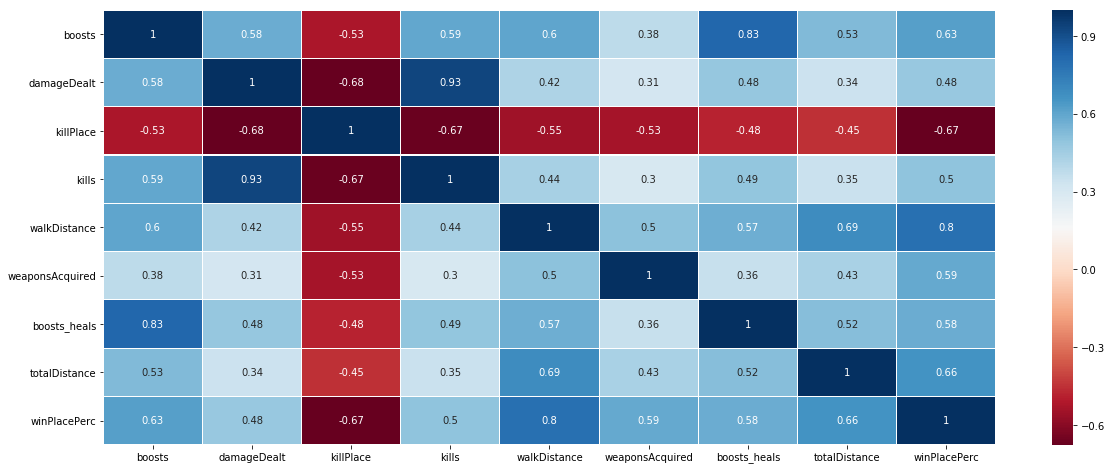

In [45]:
corr = pubg_train.corr()
plt.figure(figsize=(20,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

## 5. Labels Assign for Classification

* IDs for class labels: ['Elites'，'Experts'，'Generals'，'Rookies']

##### 5.1 Labels design
* Class 'Rookies' stand for players with   0    <= winPlacePerc >  0.4
* Class 'Generals' stand for players with  0.4  <= winPlacePerc >  0.6
* Class 'Elites' stand for players with    0.6  <= winPlacePerc >  0.8
* Class 'Experts' stand for players with   0.8  <= winPlacePerc >= 1

In [46]:
pubg_train_model = pubg_train.drop('Id',axis=1).copy() #Id is str and unique,not suitable for classification

index_a = pubg_train_model.query('(winPlacePerc >=0) and (winPlacePerc<0.4)').index

index_b = pubg_train_model.query('(winPlacePerc >=0.4) and (winPlacePerc<0.6)').index

index_c = pubg_train_model.query('(winPlacePerc >=0.6) and (winPlacePerc<=0.8)').index

index_d = pubg_train_model.query('(winPlacePerc >=0.8) and (winPlacePerc<=1)').index

In [48]:
pubg_train_model.loc[index_a,'winPlacePerc'] = 'Rookies'
pubg_train_model.loc[index_b,'winPlacePerc'] = 'Generals'
pubg_train_model.loc[index_c,'winPlacePerc'] = 'Elites'
pubg_train_model.loc[index_d,'winPlacePerc'] = 'Experts'

#### 5.2 Labels Description

In [49]:
n_observations,n_features = pubg_train_model.shape

display(pubg_train_model.groupby('winPlacePerc').size().sort_values(ascending=False))

Rookies_Perc = round((pubg_train_model.query("winPlacePerc == 'Rookies'").index.size/n_observations),2)
Generals_Perc = round((pubg_train_model.query("winPlacePerc == 'Generals'").index.size/n_observations),2)
Elites_Perc= round((pubg_train_model.query("winPlacePerc == 'Elites'").index.size/n_observations),2)
Experts_Perc= round((pubg_train_model.query("winPlacePerc == 'Experts'").index.size/n_observations),2)

print(f'Overall, we have {Rookies_Perc:.0%} players in class Rookies, {Generals_Perc:.0%} players in class Generals,\
 {Elites_Perc:.0%} players in class Elites, {Experts_Perc:.0%} players in class Experts in our dataset.')

winPlacePerc
Rookies     79096
Experts     36116
Generals    33692
Elites      32964
dtype: int64

Overall, we have 43% players in class Rookies, 19% players in class Generals, 18% players in class Elites, 20% players in class Experts in our dataset.


## 6. Machine Learning - - Classification

* KNN

### KNN Modelling

In [50]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
#from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

In [51]:
X_train, X_test, y_train, y_test = train_test_split(pubg_train_model.drop('winPlacePerc',axis=1), pubg_train_model['winPlacePerc'], test_size=.25, random_state=38)

y_train.head(5)

1231068     Rookies
4291198    Generals
620764     Generals
3765040      Elites
4446127     Experts
Name: winPlacePerc, dtype: object

In [52]:
n_samples_train, n_features = X_train.shape
n_samples_test, _ = X_test.shape
n_classes = len(np.unique(y_train))

print("Number of samples in training set: %d ( %d Rookies, %d Generals, %d Elites, %d Experts)" %
      (n_samples_train,np.sum(y_train=="Rookies"),np.sum(y_train=="Generals"),
       np.sum(y_train=="Elites"),np.sum(y_train=="Experts")))
print("Number of samples in the testing set: %d ( %d Rookies, %d Generals, %d Elites, %d Experts)" %
      (n_samples_test,np.sum(y_test=="Rookies"),np.sum(y_test=="Generals"),
       np.sum(y_test=="Elites"),np.sum(y_test=="Experts")))
print("Number of features: " +  str(n_features))
print("Number of classes: " + str(n_classes))
print("IDs for class labels: " + str(np.unique(y_train)))

Number of samples in training set: 136401 ( 59415 Rookies, 25302 Generals, 24626 Elites, 27058 Experts)
Number of samples in the testing set: 45467 ( 19681 Rookies, 8390 Generals, 8338 Elites, 9058 Experts)
Number of features: 8
Number of classes: 4
IDs for class labels: ['Elites' 'Experts' 'Generals' 'Rookies']


* We use GridSearchCV to select the most appropriate parameter:'n_neighbors'
* Then we create a optimal **Knn-clssifier**

In [53]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors':range(1,50)}
knn_cv= GridSearchCV(knn,param_grid,cv=5)

# Train the model using the training sets
knn_cv.fit(X_train,y_train)

#Predict Output
y_pred = knn_cv.predict(X_test)  

y_true = y_test

best_n = knn_cv.best_params_['n_neighbors']
best_score = knn_cv.best_score_

print(f'When n_neighbors is equal to {best_n}, this knn-classifier performs best with a score of {best_score:.2f}')

When n_neighbors is equal to 17, this knn-classifier performs best with a score of 0.73


* Save the CV results

In [59]:
cv_result = pd.DataFrame.from_dict(knn_cv.cv_results_)

with open('/Users/kris/Desktop/ProjectData/pubg-finish-placement-prediction/cv_result.csv','w') as f:
    cv_result.to_csv(f)

## 7. Model Valuation
#### 7.1 Confusion_matrix

In [54]:
# Compute confusion matrix [Row: True Labels, Cols: Predicted]
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score 

print("\n This is the confusion matrix")
cnf_mx = metrics.confusion_matrix(y_true, y_pred)
print(cnf_mx)


print("\n This is the normalized confusion matrix.")
cnf_mx_joint = cnf_mx.astype('float')/ cnf_mx.sum()
print(cnf_mx_joint)


# Accuracy.
acc = metrics.accuracy_score(y_true, y_pred)
# Display the output
print("\nAccuracy: %.3f\n" % acc)

target_names = ['Rookies','Generals','Elites','Experts']
print(metrics.classification_report(y_true,y_pred,target_names=target_names))



 This is the confusion matrix
[[ 4211  2305  1743    79]
 [ 2433  6163   316   146]
 [ 2002   283  4727  1378]
 [  158    40  1665 17818]]

 This is the normalized confusion matrix.
[[0.09261662 0.05069611 0.0383355  0.00173752]
 [0.05351134 0.13554886 0.0069501  0.00321112]
 [0.04403194 0.00622429 0.10396551 0.0303077 ]
 [0.00347505 0.00087976 0.03661997 0.39188862]]

Accuracy: 0.724

              precision    recall  f1-score   support

     Rookies       0.48      0.51      0.49      8338
    Generals       0.70      0.68      0.69      9058
      Elites       0.56      0.56      0.56      8390
     Experts       0.92      0.91      0.91     19681

   micro avg       0.72      0.72      0.72     45467
   macro avg       0.66      0.66      0.66     45467
weighted avg       0.73      0.72      0.73     45467



#### 7.2 Confusion_matrix Visulazation

Confusion matrix, without normalization
[[ 4211  2305  1743    79]
 [ 2433  6163   316   146]
 [ 2002   283  4727  1378]
 [  158    40  1665 17818]]


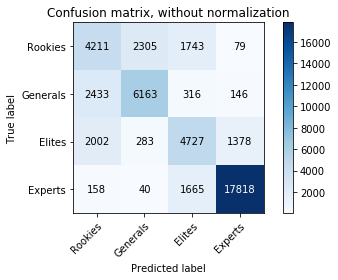

In [55]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = target_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_true, y_pred, target_names,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

#### 7.2 Cohen's Kappa

In [56]:
cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=target_names,weights='linear')

print(f"\n The cohen's kappa for this classifier is {cohen_kappa:.2f}.")


 The cohen's kappa for this classifier is 0.76.


### 7.3 Using the KNN-Classifier in the testing data

In [100]:
pubg_test_origin=pd.read_csv('/Users/kris/Desktop/ProjectData/pubg-finish-placement-prediction/test.csv')

In [110]:
pubg_test_origin=pubg_test_origin[pubg_test_origin['matchType'] == 'solo']

In [112]:
pubg_test_origin['boosts_heals'] = pubg_test_origin['boosts'] + pubg_test_origin['heals']

pubg_test_origin['totalDistance'] = pubg_test_origin['walkDistance'] + pubg_test_origin['rideDistance']+ pubg_test_origin['swimDistance']

In [114]:
pubg_test=pubg_test_origin[['walkDistance','killPlace','totalDistance','boosts','weaponsAcquired','boosts_heals',
                    'kills','damageDealt']]

In [119]:
pubg_test.head()

,walkDistance,killPlace,totalDistance,boosts,weaponsAcquired,boosts_heals,kills,damageDealt
29,436.8,20,436.8,0,2,0,2,259.20
82,273.8,85,273.8,0,2,0,0,49.18
111,294.2,70,294.2,0,2,0,0,0.00
160,0.0,54,0.0,0,0,0,0,0.00
218,918.0,55,918.0,0,3,0,0,61.43


In [120]:
test_pred = knn_cv.predict(pubg_test) 

In [132]:
knn_result=pd.DataFrame(test_pred)

In [159]:
knn_result[0].value_counts()

Rookies    76001
Experts     1988
Name: 0, dtype: int64

## 8.Linear Regression Model
* X1: boosts
* X2: killPlace
* X3: walkDistance
* y : winPlacePerc
* Interception: 0.4436

### Our estimated formular
y = 0.0229 * X1 - 0.0033 * X2 + 0.0002 * X3 + 0.4436

In [495]:
pubg_train_linear = pubg_train.drop(['Id','damageDealt','kills','boosts_heals','weaponsAcquired','totalDistance'],axis=1).copy()
pubg_train_linear.head()

,boosts,killPlace,walkDistance,winPlacePerc
36,1,24,1528.0,0.8462
63,0,79,471.9,0.2245
69,1,38,231.7,0.1573
91,0,84,292.6,0.1075
100,1,7,1913.0,0.9355


In [496]:
X_train, X_test, y_train, y_test = train_test_split(pubg_train_linear.drop('winPlacePerc',axis=1), pubg_train_linear['winPlacePerc'], test_size=.25, random_state=38)

In [497]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

reg=linear_model.LinearRegression(normalize=True)

reg.fit(X_train,y_train)
y_pred_linear=reg.predict(X_test)

#### Evaluation

In [498]:
k= list(np.around(reg.coef_ ,4))
b = np.around(reg.intercept_,4)
mean_squared_error = mean_squared_error(y_test,y_pred_linear)
r2_score = r2_score(y_test,y_pred_linear)
score = reg.score(X_train,y_train)

In [499]:
print('Each coefficents are')
print(k)
print('\n')
print('The interception is %.4f' % b)
print('The score for this model is: %.2f' % score)
print("Mean squared error: %.2f" % mean_squared_error)
print('Variance score: %.2f' % r2_score)

Each coefficents are
[0.0229, -0.0033, 0.0002]


The interception is 0.4436
The score for this model is: 0.72
Mean squared error: 0.03
Variance score: 0.73


In [500]:
features=list(pubg_train_linear.columns)
coefficient=list(k)

In [501]:
features_coefficient={}
for i,j in zip(features,coefficient):
    features_coefficient[i]=j

print('Following are the rank of independent variables based on the absolute value of their coefficient\
that related to the dependent vairable:')
      
sorted(features_coefficient.items(),key = lambda x:abs(x[1]),reverse = True)

Following are the rank of independent variables based on the absolute value of their coefficientthat related to the dependent vairable:


[('boosts', 0.0229), ('killPlace', -0.0033), ('walkDistance', 0.0002)]